The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


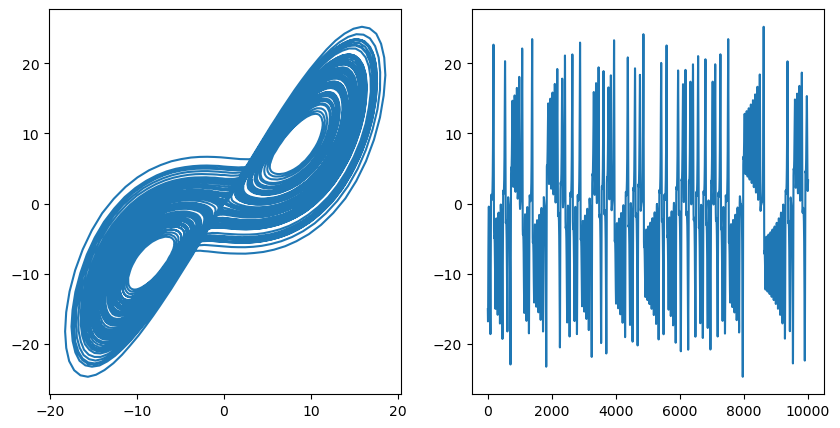

In [136]:
import matplotlib.pyplot as plt
import numpy as np
from utils import embed_signal_torch
import torch

%load_ext autoreload
%autoreload 2
from dysts.flows import Lorenz
from utils import train, make_dataset

## Load and simulate an attractor
model = Lorenz()
model.dt = 0.01
sol = model.make_trajectory(10000, resample=False, noise=0.0)

sol += np.random.normal(0, 0.01, sol.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(sol[:, 0], sol[:, 1])
ax[1].plot(sol[:, 1])

In [137]:
data = sol[:, 0:1]
var = np.var(data)
std = np.std(data)
var,std

(61.789001443145004, 7.860598033428818)

In [138]:
from sklearn.neighbors import NearestNeighbors


def find_neighbors(embedding, n_neighbors, algorithm="ball_tree"):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm=algorithm).fit(embedding)
    distances, indices = nbrs.kneighbors(embedding)
    indices = indices[:,1:]  # exclude present point
    return distances, indices


def compute_EkT(data,embedding, n_neighbors, T, thresh=10):
    #data should be 1 dimensional in the last axis
    if data.ndim == 3:
        print("multiple trajectories found, recursing")
        E_kT = []
        for i in range(data.shape[0]):
            E_kT.extend(compute_EkT(data[i],embedding[i], n_neighbors, T))
        return E_kT
    
    if T < thresh:
        data = data[:T-thresh] #remove the last thresh-T points to keep array size consistent
        embedding = embedding[:T-thresh]
    # trajs has shape (time ,dim)
    d = embedding[:-T]  # can't look at the last T
    _, indices = find_neighbors(d, n_neighbors)
    # now given the indices, we need to find the index of the point T steps after the point of a given index
    data = data[T:]
    # calculate the mean of these points for each point d
    mu_kT = np.mean(data[indices], axis=1) #* n_neighbors / (n_neighbors + 1)
    # calculate the variance of the neighborsfor each of the points d
    mu_kT = mu_kT[:, np.newaxis].repeat(n_neighbors-1, axis=1)

    E_kT = np.mean((data[indices] - mu_kT) ** 2,axis=(1,2))  # shape (time)

    # norm = 1 / (n_neighbors + 1)

    # E_kT *= norm
    return E_kT


def compute_Ek(data,embedding, n_neighbors, max_T):
    E_k = []
    for T in range(1, max_T+1):
        E_kT = compute_EkT(data,embedding, n_neighbors, T, thresh=max_T)
        E_k.append(E_kT)
        # print(T,E_kT)
    E_k = np.array(E_k)
    E_k = np.mean(E_k, axis=0)
    return E_k


def compute_eps_k(embedding, n_neighbors, thresh=10):
    if embedding.ndim == 3:
        embedding = embedding[
            :, :-thresh
        ]  # pick the data to go along with the E_k cutoff (can't look at the last T points because we need to look T steps ahead)
        embedding = embedding.reshape(-1, embedding.shape[-1])
    else:
        embedding = embedding[:-thresh]

    distances, _ = find_neighbors(embedding, n_neighbors)
    
    fact = 2 / (n_neighbors * (n_neighbors - 1))
    eps_k = np.sum(distances[:, 1:] ** 2, axis=1) #* fact

    norm_factor = 1 / np.mean(1 / eps_k)

    eps_k *= fact
    return  eps_k, norm_factor


def compute_noise_amp_k(data,embedding, n_neighbors, max_T, noise_res=0.0, normalize=False):
    if noise_res >= 0:
        embedding += np.random.uniform(-noise_res, noise_res, embedding.shape)

    E_k = compute_Ek(data,embedding, n_neighbors+1, max_T)

    eps_k, norm_factor = compute_eps_k(embedding, n_neighbors+1, max_T)

    sig = np.mean(E_k / eps_k) 
    if normalize:
        sig *= norm_factor

    return sig, E_k, eps_k

In [139]:
ndelays = 10
tau = 5
H = np.array(embed_signal_torch(data, ndelays,tau))
data_cut = data[(ndelays-1)*tau:]
H.shape,data_cut.shape

((9955, 10), (9955, 1))

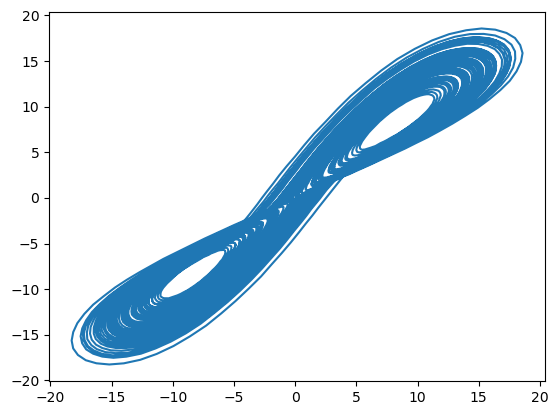

In [140]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
red = pca.fit_transform(H)

plt.plot(H[:, 0], H[:, 1])

In [143]:
nk = 4
sigs = []
eks = []
eps_ks = []
#this should saturate to data variance
for nT in range(1,2001,100):
    sigma, ek, eps_k = compute_noise_amp_k(data_cut,H, nk, nT,normalize=True)
    sigs.append(sigma)
    eks.append(ek.mean())
    eps_ks.append(eps_k.mean())
    print(sigma)


fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(sigs,label='sig')
ax[0].axhline(var,linestyle=':',c='k')
ax[1].plot(eks,label='E_k')
ax[2].plot(eps_ks,label='eps_k')  
# plt.legend()
plt.tight_layout()

0.32922767050348756
48.79918711188253
92.71185964184106
159.4333104114664


In [128]:
nk = 3
nT = 10
sigma, ek, eps_k = compute_noise_amp_k(H, nk, nT)
sigma, np.mean(ek), np.mean(eps_k)

TypeError: compute_noise_amp_k() missing 1 required positional argument: 'max_T'

In [21]:
ndelays = np.arange(3, 63, 3)
taus = [1, 2, 5, 10]

sigmas = []

for tau in taus:
    ss = []
    for ndelay in ndelays:
        print(ndelay)

        H = np.array(embed_signal_torch(data, ndelay, tau))
        sigma, _, _ = compute_noise_amp_k(H, nk, nT)
        ss.append(sigma)

    sigmas.append(ss)

3
[0.15975449 0.11483169 0.07019724 ... 0.0848379  0.11682288 0.09723552]
[0.15975449 0.11483169 0.07019724 ... 0.0848379  0.11682288 0.09723552]
[0.15975449 0.11483169 0.07019724 ... 0.0848379  0.11682288 0.09723552]
6
[0.27161047 0.19639769 0.14647798 ... 0.26086703 0.24568381 0.22655106]
[0.27161047 0.19639769 0.14647798 ... 0.26086703 0.24568381 0.22655106]
[0.27161047 0.19639769 0.14647798 ... 0.26086703 0.24568381 0.22655106]
9
[0.3469735  0.2806017  0.2125938  ... 0.40272313 0.41973722 0.42932114]
[0.3469735  0.2806017  0.2125938  ... 0.40272313 0.41973722 0.42932114]
[0.3469735  0.2806017  0.2125938  ... 0.40272313 0.41973722 0.42932114]
12
[0.38673787 0.30047756 0.27851224 ... 0.53210913 0.54239284 0.52179939]
[0.38673787 0.30047756 0.27851224 ... 0.53210913 0.54239284 0.52179939]
[0.38673787 0.30047756 0.27851224 ... 0.53210913 0.54239284 0.52179939]
15
[0.41348345 0.36969678 0.32409122 ... 0.60254929 0.648293   0.64775908]
[0.41348345 0.36969678 0.32409122 ... 0.60254929 0.6

KeyboardInterrupt: 

Text(0, 0.5, 'Noise Amplification Estimation')

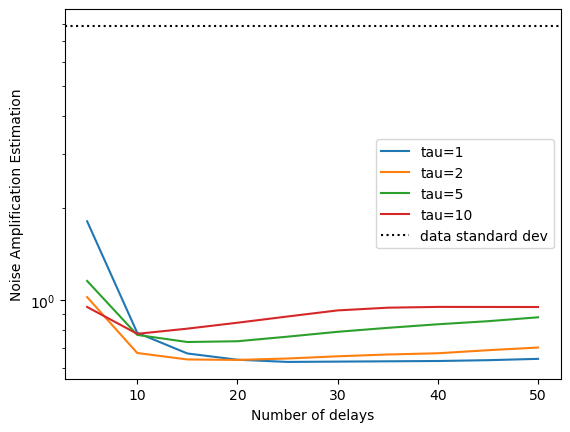

In [16]:

for i, tau in enumerate(taus):
    plt.plot(ndelays, sigmas[i], label=f"tau={tau}")
plt.axhline(std,label="data standard dev",c="k",linestyle=':')
plt.yscale("log")
plt.legend()
plt.xlabel("Number of delays")
plt.ylabel("Noise Amplification Estimation")

In [43]:
ndelays = np.arange(5, 105, 5)
taus = np.arange(1, 11, 1)
sigmas = np.zeros((ndelays.size, taus.size))
eps_ks = np.zeros((ndelays.size, taus.size))
for i, nd in enumerate(ndelays):
    for j, tau in enumerate(taus):
        print(nd, tau)

        H = np.array(embed_signal_torch(data, nd, tau))
        sig, _, eps_k = compute_noise_amp_k(H, nk, nT)

        sigmas[i, j] = sig
        eps_ks[i, j] = eps_k

5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
25 1
25 2
25 3
25 4
25 5
25 6
25 7
25 8
25 9
25 10
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
35 1
35 2
35 3
35 4
35 5
35 6
35 7
35 8
35 9
35 10
40 1
40 2
40 3
40 4
40 5
40 6
40 7
40 8
40 9
40 10
45 1
45 2
45 3
45 4
45 5
45 6
45 7
45 8
45 9
45 10
50 1
50 2
50 3
50 4
50 5
50 6
50 7
50 8
50 9
50 10
55 1
55 2
55 3
55 4
55 5
55 6
55 7
55 8
55 9
55 10
60 1
60 2
60 3
60 4
60 5
60 6
60 7
60 8
60 9
60 10
65 1
65 2
65 3
65 4
65 5
65 6
65 7
65 8
65 9
65 10
70 1
70 2
70 3
70 4
70 5
70 6
70 7
70 8
70 9
70 10
75 1
75 2
75 3
75 4
75 5
75 6
75 7
75 8
75 9
75 10
80 1
80 2
80 3
80 4
80 5
80 6
80 7
80 8
80 9
80 10
85 1
85 2
85 3
85 4
85 5
85 6
85 7
85 8
85 9
85 10
90 1


KeyboardInterrupt: 

In [40]:
# calculate the standard deviation of the time series
std = np.std(data)
std

7.63540399232588

In [42]:
sigmas

array([[346.4372307 , 208.64296839, 123.72305519,  85.08320383,
         69.67853521,  59.25125386,  51.68210708,  42.70667758,
         36.22289136,  32.71466682],
       [196.1834653 ,  73.54350176,  46.2754293 ,  33.18609001,
         27.42310618,  21.12398105,  17.12857416,  13.43665876,
         12.08759488,  10.4307712 ],
       [110.49771549,  44.9939027 ,  27.50343308,  19.56714687,
         14.45842525,  11.05910127,   9.31131031,   8.20486411,
          7.89454589,   7.5624834 ],
       [ 71.79542266,  30.32426998,  18.39902371,  12.07583882,
          9.59868761,   7.9266319 ,   7.55705847,   7.29626494,
          7.41154394,   7.26687302],
       [ 55.49099544,  23.2505988 ,  12.55935267,   9.0415066 ,
          7.84588191,   7.19299796,   7.26001167,   7.15324276,
          7.28420488,   7.14985154],
       [ 44.55072644,  17.65409202,   9.73072992,   7.77660971,
          7.28075562,   7.0144269 ,   7.1541325 ,   7.04681905,
          7.1878191 ,   7.08420356],
       [ 3

Text(0, 0.5, 'ndelays')

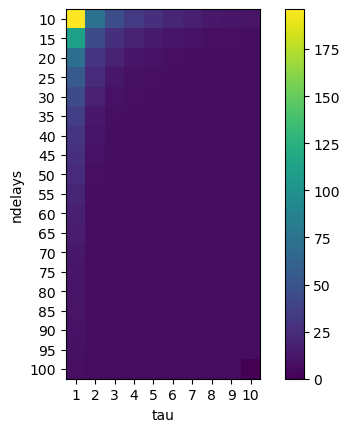

In [41]:
plt.imshow(sigmas[1:])
# add relevant ticks and labels from above
plt.xticks(np.arange(taus.size), taus)
plt.yticks(np.arange(ndelays.size - 1), ndelays[1:])
plt.colorbar()
plt.xlabel("tau")
plt.ylabel("ndelays")

In [67]:
eps = []
dd = [1, 2, 5, 10, 25, 50, 100]
for i in dd:
    H = np.array(embed_signal_torch(data, 1, i))

    eps.append(compute_eps_k(H, 10))

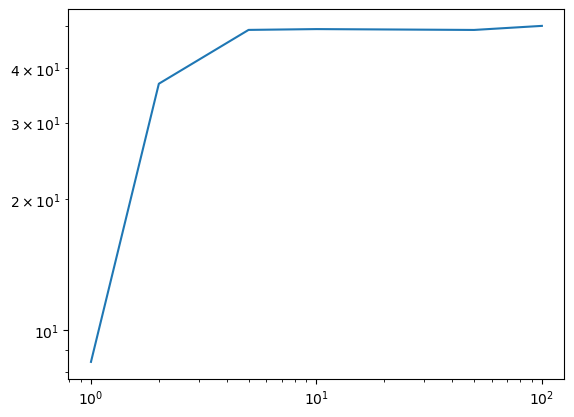

In [64]:
plt.plot(dd[: len(eps)], eps)
plt.xscale("log")
plt.yscale("log")

In [38]:
noise_amp = compute_noise_amp_k(H, 5, 20)

print(noise_amp)

35.54097418801636
52.75670969174886
80.28645346630037
121.00945875817524
181.57188745735766
276.059630795559
419.07543171212694
640.1969626481902
1004.6211076223699
1573.824766189015
2374.268560449282
3395.838586554901
4586.0740533573935
5839.174545059601
7027.216401301324
8074.447676243881
8985.233936414743
9775.623838878275
10434.614912602157
70491.5007236559


In [87]:
def compute_sigma2(x, n_ref, nn, Tm, epsm, variance_data):
    n_samples = len(x)
    sigma2_total = 0
    count_valid = 0

    # Nearest Neighbors for reference points
    nn_model = NearestNeighbors(n_neighbors=nn + 1, algorithm="auto")
    nn_model.fit(x.reshape(-1, 1))

    # Iterate over reference points
    for j in range(n_ref):
        distances, indices = nn_model.kneighbors(
            x[j].reshape(1, -1), return_distance=True
        )
        valid_indices = indices[0][
            distances.flatten() > epsm
        ].flatten()  # Apply epsm threshold
        if len(valid_indices) < nn + 1:
            print("Not enough points found")
            continue

        # Calculate local sigma squared using the vectorized variance computation
        local_sigma_squared = E2_x(x, valid_indices, Tm, variance_data)
        sigma2_total += local_sigma_squared
        count_valid += 1

    # Compute average sigma squared
    if count_valid > 0:
        average_sigma_squared = sigma2_total / count_valid
        return average_sigma_squared
    else:
        return None


def E2_x(x, indices, Tm, variance_data):
    """
    Compute normalized variance for given indices over a time window Tm.

    Parameters:
    - x: numpy array, the full time series data
    - indices: numpy array, indices of neighbors considered for variance calculation
    - Tm: int, the length of the time window to consider for each index
    - variance_data: float, the overall variance of the time series for normalization

    Returns:
    - normalized_var: float, normalized variance across the specified time window
    """
    # Precompute slices for all timesteps within the window, enhancing performance
    index_matrix = indices[:, None] + np.arange(Tm)
    values = x[index_matrix]  # Fetch values in a vectorized manner

    # Calculate mean and variance across the specified window
    mean_values = np.mean(values, axis=1)
    var = np.mean((values - mean_values[:, None]) ** 2, axis=1).mean()

    # Normalize by the overall variance of the data
    normalized_var = var / (Tm * variance_data)
    return normalized_var